In [1]:
!pip install soccerdata
# Data manipulation
import pandas as pd
import numpy as np
from soccerdata import FBref

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings for Jupyter notebooks (if applicable)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

# Statistical tests and modeling
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Optional: Machine learning setup
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Optional: Working with SQL
import sqlite3


[07/10/25 17:30:06] INFO     No custom team name replacements found. You can configure these in       ]8;id=799054;file://C:\Users\arjun\anaconda3\Lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=891657;file://C:\Users\arjun\anaconda3\Lib\site-packages\soccerdata\_config.py#91\91]8;;\
                             C:\Users\arjun\soccerdata\config\teamname_replacements.json.                          

                    INFO     No custom league dict found. You can configure additional leagues in    ]8;id=523886;file://C:\Users\arjun\anaconda3\Lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=211343;file://C:\Users\arjun\anaconda3\Lib\site-packages\soccerdata\_config.py#197\197]8;;\
                             C:\Users\arjun\soccerdata\config\league_dict.json.                                    

In [16]:
# Step 1: Fetch Stats
fb = FBref(leagues="ENG-Premier League", seasons="2024-2025")

standard = fb.read_player_season_stats(stat_type="standard")
shooting = fb.read_player_season_stats(stat_type="shooting")
passing = fb.read_player_season_stats(stat_type="passing")
possession = fb.read_player_season_stats(stat_type="possession")
defense = fb.read_player_season_stats(stat_type="defense")

# Step 2: Reset Index to Expose 'Player' and 'Squad' Columns
for df in [standard, shooting, passing, possession, defense]:
    df.reset_index(inplace=True)

# Step 3: Filter for Forwards using Position Column
# 'Pos' column is found in the 'Standard' stats
strikers = standard[standard[('pos', '')] == 'FW'].copy()

# Step 4: Merge All Stats into Strikers Table (exclude re-merging with standard)
def merge_stats(df, new_df):
    return df.merge(new_df, on=['player', 'team'], suffixes=(None, f'_dup'))

strikers = merge_stats(strikers, shooting)
strikers = merge_stats(strikers, passing)
strikers = merge_stats(strikers, possession)
strikers = merge_stats(strikers, defense)

[07/10/25 18:01:26] INFO     Saving cached data to C:\Users\arjun\soccerdata\data\FBref              ]8;id=77263;file://C:\Users\arjun\anaconda3\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=526979;file://C:\Users\arjun\anaconda3\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

In [22]:
print(strikers.columns.tolist())

[('league', ''), ('season', ''), ('team', ''), ('player', ''), ('nation', ''), ('pos', ''), ('age', ''), ('born', ''), ('Playing Time', 'MP'), ('Playing Time', 'Starts'), ('Playing Time', 'Min'), ('Playing Time', '90s'), ('Performance', 'Gls'), ('Performance', 'Ast'), ('Performance', 'G+A'), ('Performance', 'G-PK'), ('Performance', 'PK'), ('Performance', 'PKatt'), ('Performance', 'CrdY'), ('Performance', 'CrdR'), ('Expected', 'xG'), ('Expected', 'npxG'), ('Expected', 'xAG'), ('Expected', 'npxG+xAG'), ('Progression', 'PrgC'), ('Progression', 'PrgP'), ('Progression', 'PrgR'), ('Per 90 Minutes', 'Gls'), ('Per 90 Minutes', 'Ast'), ('Per 90 Minutes', 'G+A'), ('Per 90 Minutes', 'G-PK'), ('Per 90 Minutes', 'G+A-PK'), ('Per 90 Minutes', 'xG'), ('Per 90 Minutes', 'xAG'), ('Per 90 Minutes', 'xG+xAG'), ('Per 90 Minutes', 'npxG'), ('Per 90 Minutes', 'npxG+xAG'), ('league_dup', ''), ('season_dup', ''), ('nation_dup', ''), ('pos_dup', ''), ('age_dup', ''), ('born_dup', ''), ('90s', ''), ('Standard',

In [27]:
# Flatten columns
strikers.columns = ['_'.join(filter(None, map(str, col))).strip() for col in strikers.columns.values]

# Replace 'Playing Time_90s' with a variable
per90_col = 'Playing Time_90s'

cols_to_per90_flat = [
    'Touches_Att Pen',
    'Carries_PrgC',
    'Carries_Carries',
    'Carries_PrgDist',
    'Tackles_Tkl',
    'Challenges_Tkl',
    'Take-Ons_Att',
    'Take-Ons_Succ',
]

for col in cols_to_per90_flat:
    new_col = col + '_per90'
    strikers[new_col] = strikers[col] / strikers[per90_col]

# Use new flat column names in your features list
features = [
    'Standard_Sh/90',
    'Per 90 Minutes_Gls',
    'Per 90 Minutes_xG',
    'Per 90 Minutes_Ast',
    'Per 90 Minutes_xAG',
    'Touches_Att Pen_per90',
    'Carries_PrgC_per90',
    'Carries_Carries_per90',
    'Carries_PrgDist_per90',
    'Tackles_Tkl_per90',
    'Challenges_Tkl_per90',
    'Take-Ons_Att_per90',
    'Take-Ons_Succ_per90',
]


In [26]:
cols_to_per90 = [
    ('Touches', 'Att Pen'),
    ('Carries', 'PrgC'),
    ('Carries', 'Carries'),
    ('Carries', 'PrgDist'),
    ('Tackles', 'Tkl'),
    ('Challenges', 'Tkl'),
    ('Take-Ons', 'Att'),
    ('Take-Ons', 'Succ'),
]

for col in cols_to_per90:
    new_col = (col[0], col[1] + '_per90')
    strikers[new_col] = strikers.loc[:, col] / strikers.loc[:, ('Playing Time', '90s')]


ValueError: Cannot set a DataFrame with multiple columns to the single column ('Touches', 'Att Pen_per90')

In [29]:
strikers.head()

,league,season,team,player,nation,pos,age,born,Playing Time_MP,Playing Time_Starts,Playing Time_Min,Playing Time_90s,Performance_Gls,Performance_Ast,Performance_G+A,Performance_G-PK,Performance_PK,Performance_PKatt,Performance_CrdY,Performance_CrdR,Expected_xG,Expected_npxG,Expected_xAG,Expected_npxG+xAG,Progression_PrgC,Progression_PrgP,Progression_PrgR,Per 90 Minutes_Gls,Per 90 Minutes_Ast,Per 90 Minutes_G+A,Per 90 Minutes_G-PK,Per 90 Minutes_G+A-PK,Per 90 Minutes_xG,Per 90 Minutes_xAG,Per 90 Minutes_xG+xAG,Per 90 Minutes_npxG,Per 90 Minutes_npxG+xAG,league_dup,season_dup,nation_dup,pos_dup,age_dup,born_dup,90s,Standard_Gls,Standard_Sh,Standard_SoT,Standard_SoT%,Standard_Sh/90,Standard_SoT/90,Standard_G/Sh,Standard_G/SoT,Standard_Dist,Standard_FK,Standard_PK,Standard_PKatt,Expected_dup_xG,Expected_dup_npxG,Expected_dup_npxG/Sh,Expected_dup_G-xG,Expected_dup_np:G-xG,league_dup,season_dup,nation_dup,pos_dup,age_dup,born_dup,90s_dup,Total_Cmp,Total_Att,Total_Cmp%,Total_TotDist,Total_PrgDist,Short_Cmp,Short_Att,Short_Cmp%,Medium_Cmp,Medium_Att,Medium_Cmp%,Long_Cmp,Long_Att,Long_Cmp%,Ast,xAG,Expected_xA,Expected_A-xAG,KP,1/3,PPA,CrsPA,PrgP,league_dup,season_dup,nation_dup,pos_dup,age_dup,born_dup,90s_dup,Touches_Touches,Touches_Def Pen,Touches_Def 3rd,Touches_Mid 3rd,Touches_Att 3rd,Touches_Att Pen,Touches_Live,Take-Ons_Att,Take-Ons_Succ,Take-Ons_Succ%,Take-Ons_Tkld,Take-Ons_Tkld%,Carries_Carries,Carries_TotDist,Carries_PrgDist,Carries_PrgC,Carries_1/3,Carries_CPA,Carries_Mis,Carries_Dis,Receiving_Rec,Receiving_PrgR,league_dup,season_dup,nation_dup,pos_dup,age_dup,born_dup,90s_dup,Tackles_Tkl,Tackles_TklW,Tackles_Def 3rd,Tackles_Mid 3rd,Tackles_Att 3rd,Challenges_Tkl,Challenges_Att,Challenges_Tkl%,Challenges_Lost,Blocks_Blocks,Blocks_Sh,Blocks_Pass,Int,Tkl+Int,Clr,Err,Touches_Att Pen_per90,Carries_PrgC_per90,Carries_Carries_per90,Carries_PrgDist_per90,Tackles_Tkl_per90,Challenges_Tkl_per90,Take-Ons_Att_per90,Take-Ons_Succ_per90
0,ENG-Premier League,2425,Arsenal,Gabriel Jesus,BRA,FW,27,1997,17,6,608,6.80,3,0,3,3,0,0,4,0,3.00,3.00,0.70,3.70,15,19,57,0.44,0.00,0.44,0.44,0.44,0.44,0.10,0.54,0.44,0.54,ENG-Premier League,2425,BRA,FW,27,1997,6.80,3,20,7,35.00,2.96,1.04,0.15,0.43,11.10,0,0,0,3.00,3.00,0.15,0.00,0.00,ENG-Premier League,2425,BRA,FW,27,1997,6.80,156,203,76.80,2030,378,103,128,80.50,41,47,87.20,4,6,66.70,0,0.70,0.50,-0.70,8,10,9,1,19,ENG-Premier League,2425,BRA,FW,27,1997,6.80,299,9,28,108,165,48,299,22,9,40.90,10,45.50,179,953,432,15,6,11,13,13,217,57,ENG-Premier League,2425,BRA,FW,27,1997,6.80,10,6,4,3,3,4,9,44.40,5,10,1,9,4,14,8,0,7.06,2.21,26.32,63.53,1.47,0.59,3.24,1.32
1,ENG-Premier League,2425,Arsenal,Leandro Trossard,BEL,FW,29,1994,38,28,2546,28.30,8,7,15,8,0,0,4,1,7.20,7.20,6.10,13.30,80,101,226,0.28,0.25,0.53,0.28,0.53,0.25,0.22,0.47,0.25,0.47,ENG-Premier League,2425,BEL,FW,29,1994,28.30,8,72,21,29.20,2.55,0.74,0.11,0.38,15.90,0,0,0,7.20,7.20,0.10,0.80,0.80,ENG-Premier League,2425,BEL,FW,29,1994,28.30,711,954,74.50,11435,2972,377,439,85.90,275,357,77.00,43,87,49.40,7,6.10,4.10,0.90,41,45,48,10,101,ENG-Premier League,2425,BEL,FW,29,1994,28.30,1278,17,135,399,762,158,1278,86,38,44.20,37,43.00,828,5024,2218,80,55,30,66,52,956,226,ENG-Premier League,2425,BEL,FW,29,1994,28.30,31,20,6,16,9,12,34,35.30,22,32,0,32,9,40,18,0,5.58,2.83,29.26,78.37,1.10,0.42,3.04,1.34
2,ENG-Premier League,2425,Arsenal,Nathan Butler-Oyedeji,ENG,FW,21,2003,1,0,7,0.10,0,0,0,0,0,0,0,0,0.10,0.10,0.00,0.10,0,0,0,0.00,0.00,0.00,0.00,0.00,0.94,0.00,0.94,0.94,0.94,ENG-Premier League,2425,ENG,FW,21,2003,0.10,0,1,1,100.00,12.86,12.86,0.00,0.00,15.60,0,0,0,0.10,0.10,0.07,-0.10,-0.10,ENG-Premier League,2425,ENG,FW,21,2003,0.10,0,0,<NA>,0,0,0,0,<NA>,0,0,<NA>,0,0,<NA>,0,0.00,0.00,0.00,0,0,0,0,0,ENG-Premier League,2425,ENG,FW,21,2003,0.10,1,0,0,0,1,1,1,0,0,<NA>,0,<NA>,0,0,0,0,0,0,0,0,0,0,ENG-Premier League,2425,ENG,FW,21,2003,0.10,0,0,0,0,0,0,0,<NA>,0,0,0,0,0,0,0,0,10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,ENG-Premier League,2425,Arsenal,Reiss Nelson,ENG,FW

In [50]:
strikers = strikers[strikers[('Playing Time_90s')] >= 5].copy()
strikers[('Playing Time_90s')] = strikers[('Playing Time_90s')].replace(0, np.nan)

In [51]:
print(np.isinf(strikers_clean[features]).sum())  # counts of infinite values per column

Standard_Sh/90           0
Per 90 Minutes_Gls       0
Per 90 Minutes_xG        0
Per 90 Minutes_Ast       0
Per 90 Minutes_xAG       0
Touches_Att Pen_per90    0
Carries_PrgC_per90       0
Carries_Carries_per90    0
Carries_PrgDist_per90    0
Tackles_Tkl_per90        0
Challenges_Tkl_per90     0
Take-Ons_Att_per90       0
Take-Ons_Succ_per90      0
dtype: Int32


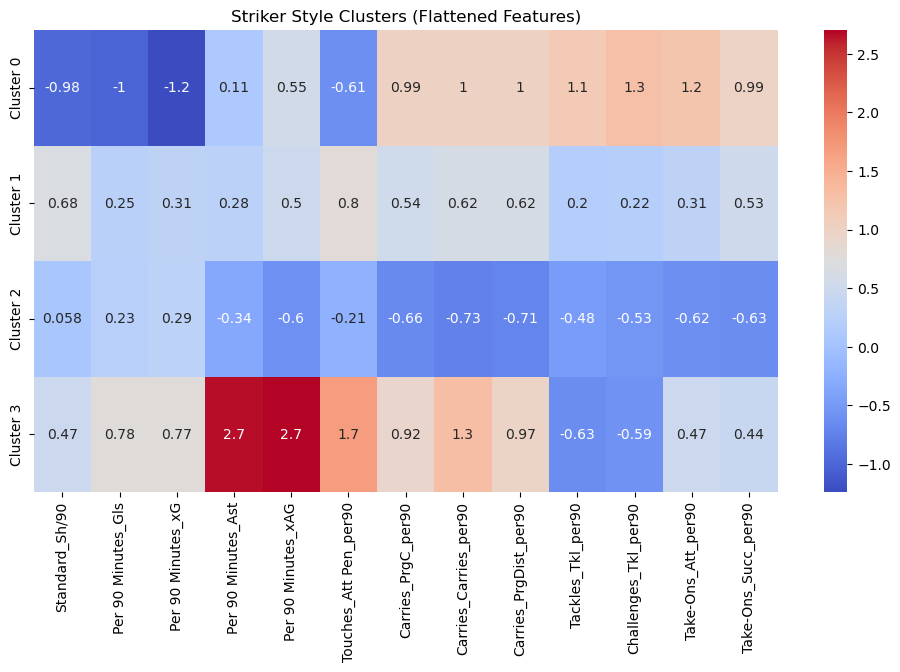

In [52]:
strikers_clean = strikers.dropna(subset=features).copy()

# Step 6: Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(strikers_clean[features])

# Step 7: KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
strikers_clean['cluster'] = kmeans.fit_predict(X)

# Step 8: Visualize Cluster Centers
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=features)

plt.figure(figsize=(12, 6))
sns.heatmap(centroids, annot=True, cmap="coolwarm", yticklabels=[f"Cluster {i}" for i in range(4)])
plt.title("Striker Style Clusters (Flattened Features)")
plt.show()

# Step 9: Inspect Clustered Players
cols_to_show = ['player', 'team', 'cluster'] + features

In [53]:
strikers_clean[cols_to_show].sort_values('cluster').head(50)

,player,team,cluster,Standard_Sh/90,Per 90 Minutes_Gls,Per 90 Minutes_xG,Per 90 Minutes_Ast,Per 90 Minutes_xAG,Touches_Att Pen_per90,Carries_PrgC_per90,Carries_Carries_per90,Carries_PrgDist_per90,Tackles_Tkl_per90,Challenges_Tkl_per90,Take-Ons_Att_per90,Take-Ons_Succ_per90
46,Kasey McAteer,Leicester City,0,1.37,0.11,0.11,0.11,0.08,3.16,2.00,23.58,60.53,2.42,1.47,2.63,0.63
42,Abdul Fatawu Issahaku,Leicester City,0,2.02,0.00,0.06,0.31,0.24,4.06,6.56,33.91,164.84,3.28,1.72,10.78,4.53
77,Mathys Tel,Tottenham,0,2.17,0.20,0.29,0.10,0.25,3.96,2.77,26.34,79.70,1.58,0.50,5.25,1.49
36,Reiss Nelson,Fulham,0,2.22,0.18,0.20,0.18,0.18,6.48,8.33,47.96,177.78,1.48,0.93,6.48,2.41
34,Jesper Lindstrøm,Everton,0,2.03,0.00,0.15,0.07,0.15,2.90,2.17,21.88,56.52,3.26,1.38,3.12,0.58
33,Jack Harrison,Everton,0,1.26,0.04,0.15,0.00,0.16,2.99,3.16,22.68,70.95,1.39,0.65,3.25,1.04
32,Iliman Ndiaye,Everton,0,1.30,0.33,0.23,0.00,0.07,3.07,3.19,23.00,87.67,1.96,0.81,5.30,2.52
21,Jadon Sancho,Chelsea,0,1.22,0.15,0.11,0.20,0.19,6.17,5.20,33.32,124.23,0.66,0.26,4.95,2.30
65,Jacob Murphy,Newcastle Utd,0,1.64,0.31,0.22,0.46,0.34,3.51,3.02,27.98,89.27,1.07,0.76,2.63,1.34
48,Stephy Mavididi,Leicester City,0,1.45,0.22,0.10,0.06,0.15,3.41,5.08,32.57,131.56,1.90,0.78,5.31,1.96


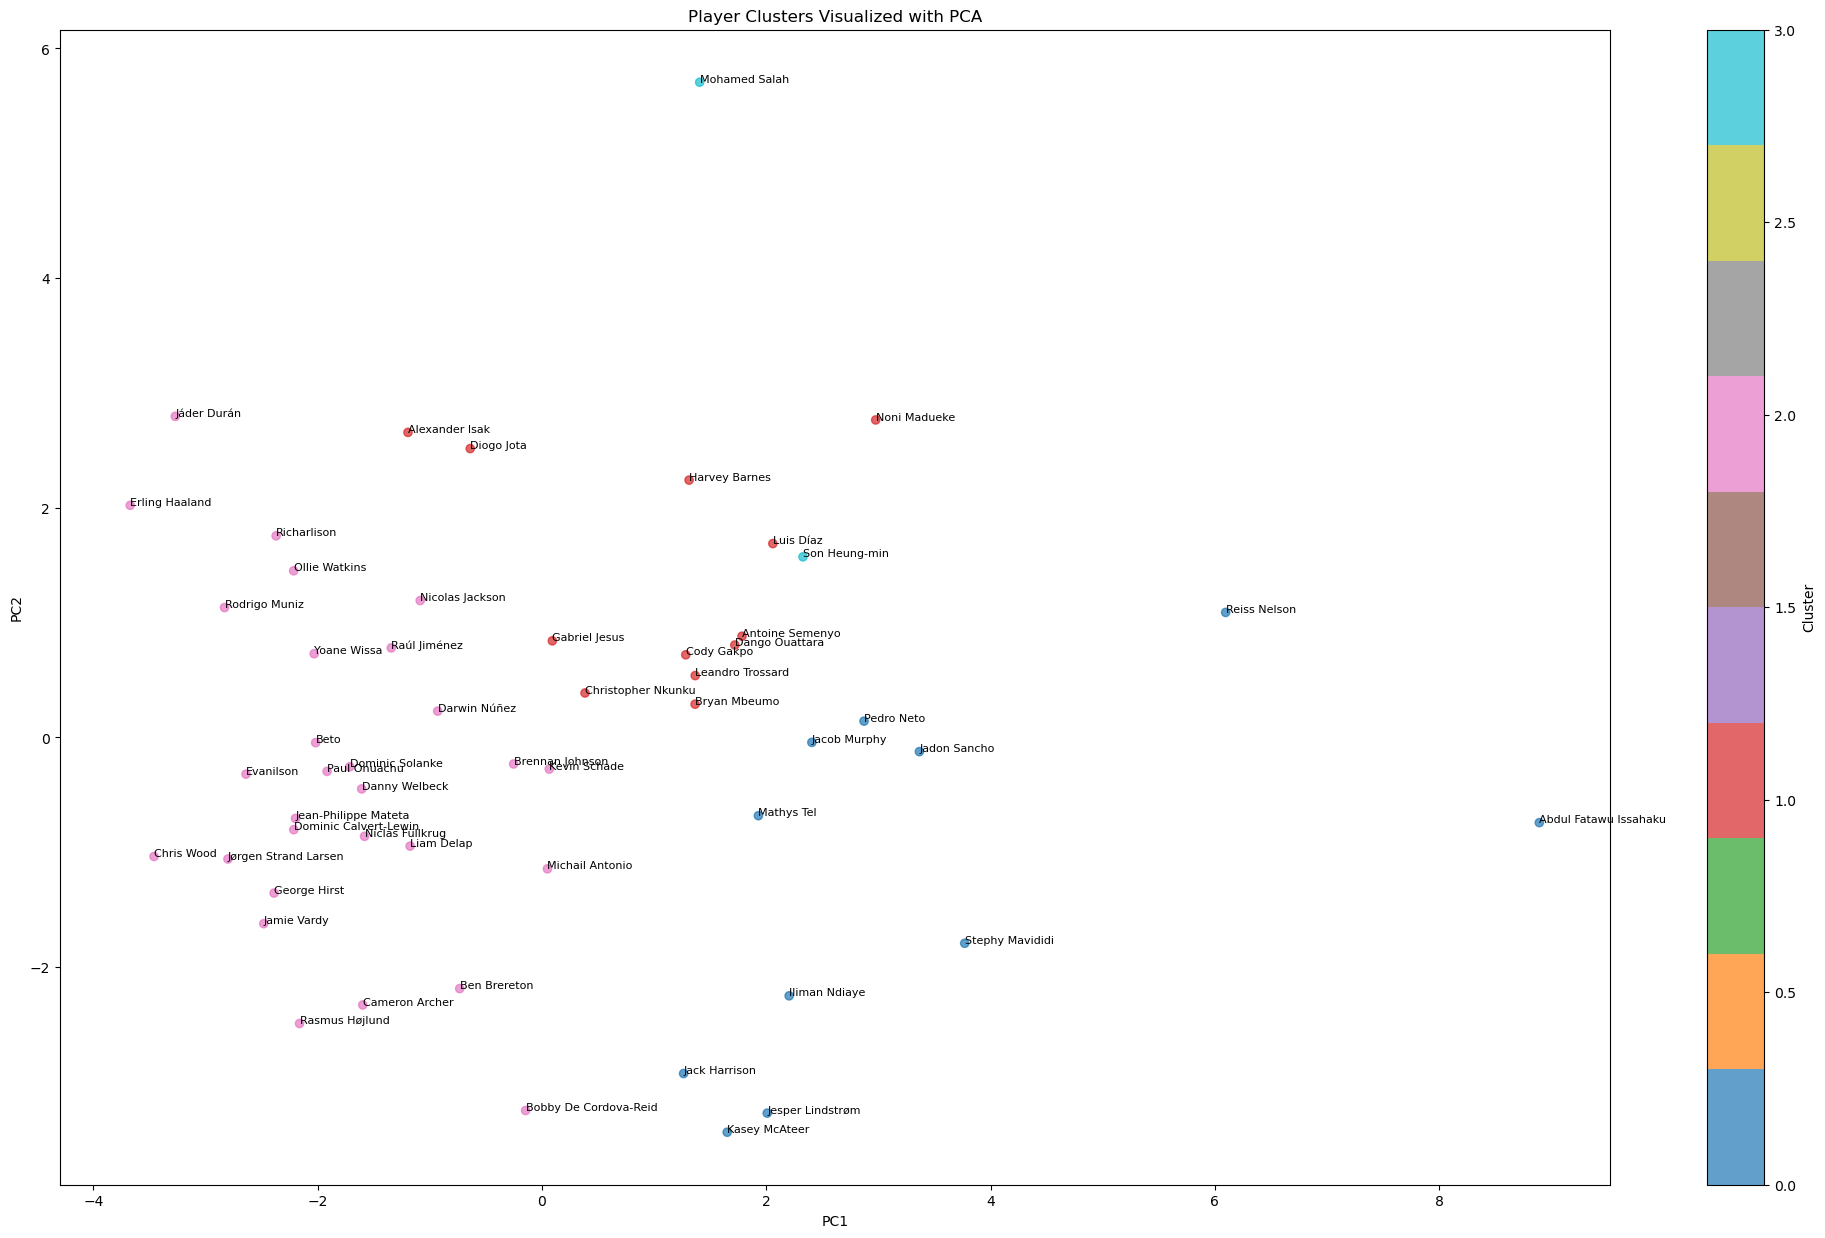

In [54]:
from sklearn.decomposition import PCA
# Reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(25, 15))  # Wider and taller figure
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=strikers_clean['cluster'], cmap='tab10', alpha=0.7)

# Annotate some points (all or a sample)
for i, player in enumerate(strikers_clean['player']):
    plt.text(X_pca[i, 0], X_pca[i, 1], player, fontsize=8)

plt.colorbar(scatter, label='Cluster')
plt.title('Player Clusters Visualized with PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()
